In [48]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, LinearLocator)
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mtick
from collections import OrderedDict
import pandas as pd
import numpy as np
# import dill
import argparse
import pyrep.backend.sim as sim
from networks.structures import PolicyNetwork, ValueNetwork, SoftQNetwork
import torch

from sim_framework.envs.drone_env import DroneEnv


%matplotlib inline

# Utils

In [20]:
def state_to_tensor(state, device):
    """Transform numpy array to torch tensor"""
    if args.use_double:
        return torch.DoubleTensor(state).unsqueeze(0).to(device)
    else:
        return torch.FloatTensor(state).unsqueeze(0).to(device)

In [21]:
class Args():
    def __init__(self):
        pass


args = Args()

In [22]:
def rollouts(env, policy, action_range, device,  max_timesteps=1000,  time_horizon=250):
    """
    Perform policy rollouts until a max given number of steps

    Parameters
    ----------
    env : 
        A larocs_sim environment
    policy : 
        An actor-policy for the agent act in the environment
    action_range : list
        Range of possible float values for the action
    max_timesteps : int, optional
        Number of timesteps to perform while interacting with the environment, by default 1000
    time_horizon : int, optional
        The number of steps for each episode, by default 250

    """
    count = 0
    dones = False
    set_of_obs, set_of_next_obs, set_of_rewards, set_of_actions, set_of_dones, set_of_infos = [], [], [], [], [], []

    rollout = -1

    while True:
        mb_obs, mb_next_obs, mb_rewards, mb_actions, mb_dones, mb_infos = [], [], [], [], [], []
        sim.simRemoveBanner(sim.sim_handle_all)
        rollout += 1

        obs0 = env.reset()

        sim.simAddBanner(label="Rollout = {0}".format(rollout).encode('ascii'),
                         size=0.2,
                         options=1,
                         positionAndEulerAngles=[0, 0, 2.5, 1.3, 0, 0],
                         parentObjectHandle=-1)

        for j in range(time_horizon):
            dones = False
            if count == max_timesteps:
                set_tau = {'obs': set_of_obs,
                           'next_obs': set_of_next_obs,
                           'rewards': set_of_rewards,
                           'actions': set_of_actions,
                           'dones': set_of_dones,
                           'infos': set_of_infos}
                return set_tau
            try:
                actions, agent_info = policy.deterministic_action(
                    state_to_tensor(obs0, device))
            except:
                actions = policy.deterministic_action(
                    state_to_tensor(obs0, device))

            # Take actions in env and look the results
            obs1, rewards, dones, infos = env.step(actions*action_range[1])
            # Append on the experience buffers
            mb_obs.append(obs0.copy())
            # mb_obs.append(obs0)
            mb_next_obs.append(obs1)
            mb_actions.append(actions)
            mb_dones.append(dones)
            mb_rewards.append(rewards)
            mb_infos.append(infos)

            count += 1

            if dones == True:
                break

            obs0 = obs1

        print()
        print('rewards: mean = {0}'.format(np.mean(mb_rewards)))
        print('rewards: sum = {0}'.format(np.sum(mb_rewards)))

        set_of_obs.append(mb_obs)
        set_of_next_obs.append(mb_next_obs)
        set_of_rewards.append(mb_rewards)
        set_of_actions.append(mb_actions)
        set_of_dones.append(mb_dones)
        set_of_infos.append(mb_infos)

In [23]:
def run_policy(args):
    """
    Loads a and evaluates a trained policy  

    Parameters
    ----------
    args : [dict]
        Users arguments with the options for the framework
    """

    use_cuda = torch.cuda.is_available()
    if use_cuda and (args.use_cuda == True):
        device=torch.device("cuda")
    else:
        device=torch.device("cpu")

        
    try:
        env.shutdown()
    except:
        pass

    # Set environment
    env = DroneEnv(random=args.env_reset_mode, headless=args.headless, seed=args.seed, 
        reward_function_name=args.reward_function,state=args.state)

    restore_path = args.file    
    print('Loading')
    # Load parameters if necessary
    try:
        checkpoint = torch.load(restore_path, map_location='cpu')
    except:
        checkpoint = torch.load(restore_path, map_location=torch.device('cpu'))
    print('Finished Loading')

    # Neural network parameters
    try:
        state_dim = env.observation_space.shape[0]
    except:
        state_dim = env.observation_space
    action_dim = env.action_space.shape[0]
    hidden_dim = checkpoint['linear1.weight'].data.shape[0]
    action_range = [env.agent.action_space.low.min(), env.agent.action_space.high.max()]
    size_obs = checkpoint['linear1.weight'].data.shape[1]

    assert size_obs == state_dim, 'Checkpoint state must be the same as the env'

    
   # Networks instantiation
    policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)


    # Loading  Models
    policy_net.load_state_dict(checkpoint)
    print('Finished Loading the weights')

    print("Running the policy with time_horizon = ...",  args.H)
    set_tau = rollouts(env, policy_net,\
            action_range, device, max_timesteps = args.max_timesteps,  time_horizon=args.H)
    
    print('Closing env')
    env.shutdown()

    return set_tau

# Parameters

In [49]:
args.reward_function='Normal'
args.env_reset_mode='Discretized_Uniform'
args.state='New_action'
args.seed=42
args.file='../saved_policies/sac_optimal_policy_2.pt'
args.max_timesteps=250
args.H=250
args.use_double=False
args.headless=False

# Running

In [50]:
try: ## hack for jupyter
    env.shutdown()
except:
    pass
set_tau = run_policy(args)

Loading
Finished Loading
Finished Loading the weights
Running the policy with time_horizon = ... 250

rewards: mean = 3.71689232771041
rewards: sum = 929.2230819276025
Closing env


# Plotting

In [46]:
## Take the first rollout of our evaluation phase
rollouts_array = np.array(set_tau['actions'][0]).squeeze()
## Transform in pandas DataFrame
df = pd.DataFrame(rollouts_array, columns=['Propeller_{0}'.format(x) for x in range(1,5,1)])
## Multiply by our timestep (0.05 s)
index = [np.round((x+1)*0.05,3) for x in df.index]
df.index = index
## Our agent action_range is [-100,100]
df = df.mul(100)

Text(0, 0.5, 'MOTOR 4 PWM - [-100,100]')

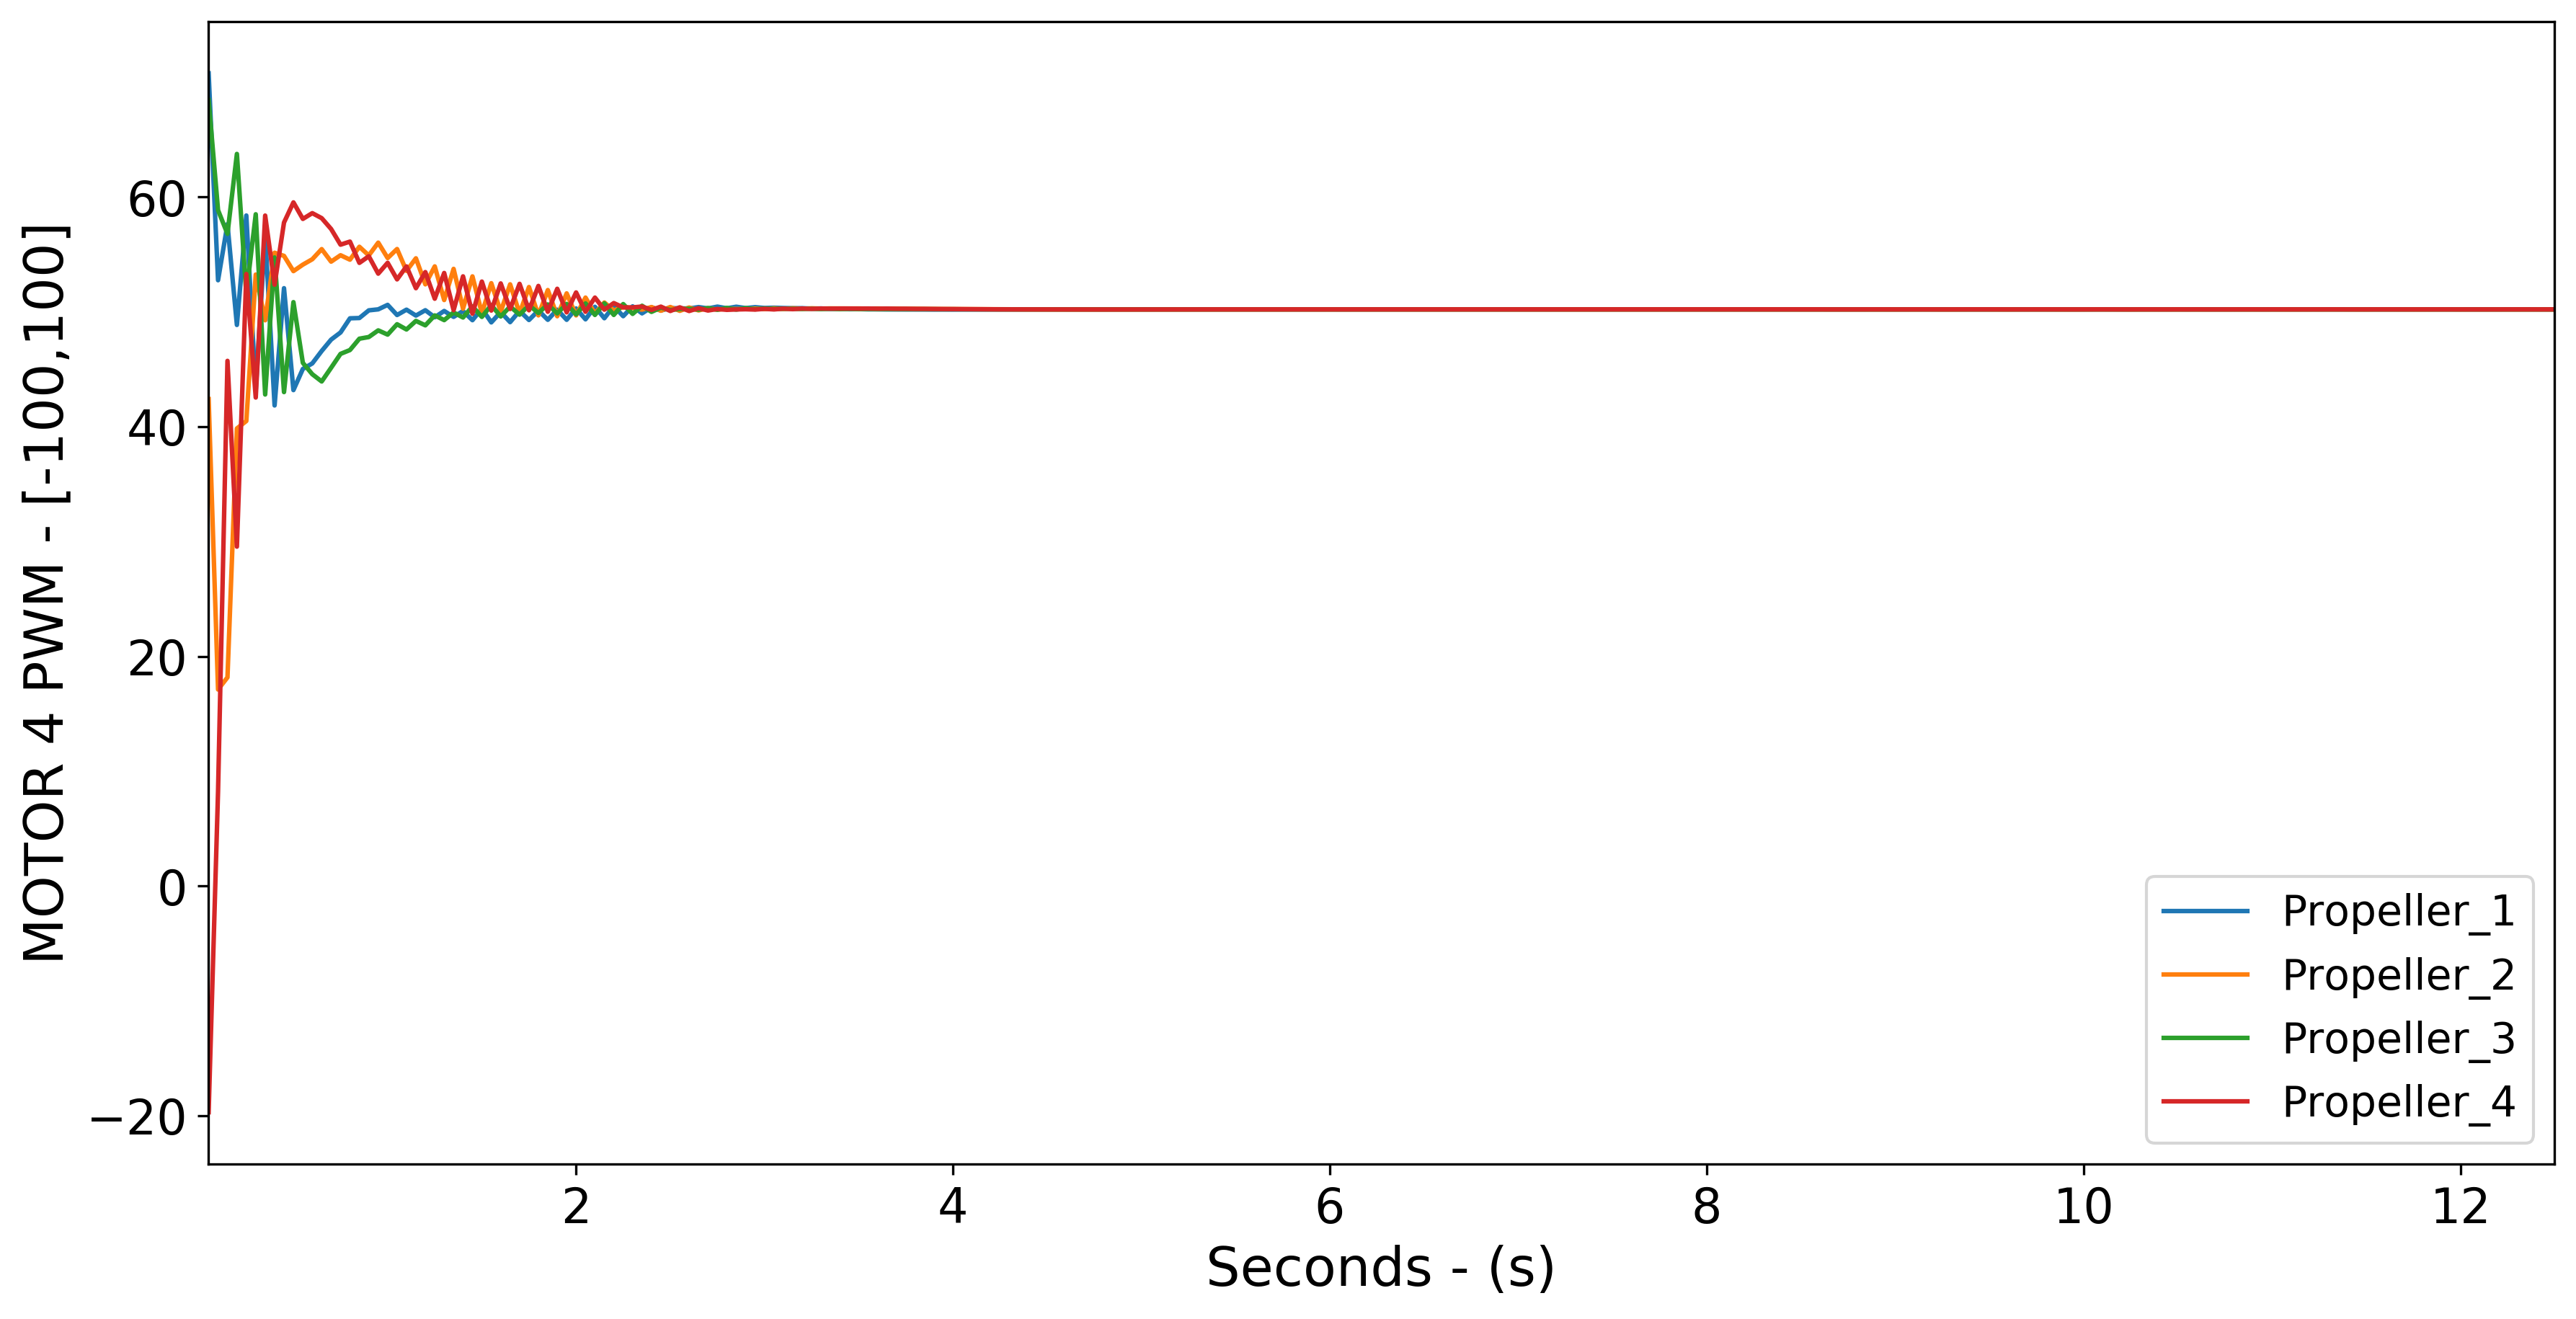

In [47]:
## Plotting
fig,ax = plt.subplots(figsize=(14,7), dpi=300)
df.plot(ax = ax)
plt.legend(prop = {'size' : 14}, loc='lower right')
plt.tick_params(which='both', labelsize=16)
plt.xlabel('Seconds - (s)',  size=18)
plt.ylabel('MOTOR 4 PWM - [-100,100]',  size=18)
